In [1]:
import torchvision
from tqdm import tqdm
import numpy as np
from utils.transforms import *
import matplotlib.pyplot as plt
import re
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import random

/home/nazim/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('local/collected_data_with_crop.txt', 'r') as file:
    # lines = file.readlines()
    data = file.read().strip()
    
epochs_lines = data.split('\n\n\n\n\n\n\n')

In [3]:
ops = ['Bri', 'Col', 'Con', 'Sha', 'Rot', 'She', 'Tra', 'Aut', 'Equ', 'Inv', 'Pos', 'Sol', 'flip']

In [4]:
def line2parts(line):
    parts = ['']
    for i in range(len(line)):
        if line[i] == ',' and line[i+1] != ' ':
            parts.append('')
        else:
            parts[-1] += line[i]
    
    return parts

def process_part(input_string):

    # Input string
    # input_string = "Pos 0.35 Cut 0.02 crop [0, 9, 17, 31] flip 0"

    # Regular expression to match the pattern
    pattern = r'(\w+)\s(\[.*?\]|\d+\.\d+|\d+)'

    # Find all matches
    matches = re.findall(pattern, input_string)

    # Convert matches to the desired format
    result = [(match[0], eval(match[1])) for match in matches]

    # Print the result
    return result


def intersection_over_union(boxA, boxB):
    # Extract the coordinates of the two boxes
    topA, leftA, bottomA, rightA = boxA
    topB, leftB, bottomB, rightB = boxB
    
    # Determine the coordinates of the intersection rectangle
    interTop = max(topA, topB)
    interLeft = max(leftA, leftB)
    interBottom = min(bottomA, bottomB)
    interRight = min(rightA, rightB)
    
    # Compute the area of the intersection rectangle
    interWidth = max(0, interRight - interLeft)
    interHeight = max(0, interBottom - interTop)
    interArea = interWidth * interHeight
    
    # Compute the area of both bounding boxes
    boxAArea = (rightA - leftA) * (bottomA - topA)
    boxBArea = (rightB - leftB) * (bottomB - topB)
    
    # Compute the Intersection over Union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou


def lvl2strength(trans, lvl):
    if trans in ['Bri', 'Col', 'Con', 'Sha', 'Rot', 'She', 'Tra']:
        val = 2*lvl - 1
    elif trans in ['Aut', 'Equ', 'Inv']:
        val = 1
    elif trans == 'Pos':
        val = 0.8*lvl + 0.2
    elif trans == 'Sol':
        val = 1 - lvl/256
    else:
        return trans, lvl
    return trans, val


def parts2vector(x1_x2_sim):
    x1, x2, sim = x1_x2_sim
    
    vec1, vec2 = np.zeros((len(ops),)), np.zeros((len(ops),))
    
    x1 = list(  map( lambda e: lvl2strength(e[0], e[1]) , x1 )  )
    x2 = list(  map( lambda e: lvl2strength(e[0], e[1]) , x2 )  )
    
    for trans, val in x1:
        if trans in ops:
            vec1[ops.index(trans)] = val
    
    for trans, val in x2:
        if trans in ops:
            vec2[ops.index(trans)] = val
        
    # print(vec1, vec2)
    # return  sum(abs(vec1)) + sum(abs(vec2))
    
    iou = intersection_over_union(x1[-2][1], x2[-2][1])

    return  np.concatenate((
        abs(vec1 - vec2),
        # vec1, vec2,  
        [1-iou]
    ))


# parts2vector(x1_x2_sim[0])

In [5]:
def epoch2vectors(epoch, samples=None):
    lines = epoch.strip().split('\n')
    if samples is not None:
        lines = random.sample(lines, samples)
    
    random.shuffle(lines)

    x1_x2_sim = []
    for line in lines:
        x1, x2, sim = line2parts(line)
        x1 = process_part(x1)
        x2 = process_part(x2)
        x1_x2_sim.append((x1, x2, float(sim)))
            
    vectors = list(map(parts2vector, x1_x2_sim))
    sims = list(map(lambda e:e[2], x1_x2_sim))
    
    return vectors, sims

train loss: 0.10535906657783438
test loss: 0.10479621608931974
next loss: 0.10376404471646357
Correlation train: 0.47644464957809096
Correlation test: 0.4906498522671423


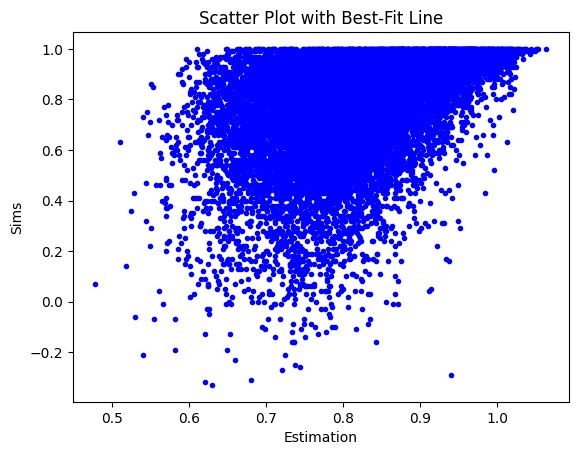

In [6]:
# for epoch in tqdm(epochs_lines):

i = 50
vec_i, sims_i = epoch2vectors(epochs_lines[i])
vec_j, sims_j = epoch2vectors(epochs_lines[i+1])
    
    
# X = np.array(strengths)
# Y = np.array(sims)

s = 30000
X_train_i, y_train_i, X_test_i, y_test_i = vec_i[:s], sims_i[:s], vec_i[s:], sims_i[s:]
# X_train_j, y_train_j, X_test_j, y_test_j = vec_j[:s], sims_j[:s], vec_j[s:], sims_j[s:]

model = LinearRegression()
# model = MLPRegressor(hidden_layer_sizes=(512,512), max_iter=1000, random_state=42, activation='relu')
model.fit(X_train_i, y_train_i)


pred_train_i = model.predict(X_train_i)
pred_test_i  = model.predict(X_test_i)
pred_j  = model.predict(vec_j)

print('train loss:', abs(y_train_i - pred_train_i).mean())
print('test loss:', abs(y_test_i - pred_test_i).mean())
print('next loss:', abs(sims_j - pred_j).mean())

print("Correlation train:", np.corrcoef(pred_train_i, y_train_i)[0, 1])
print("Correlation test:", np.corrcoef(pred_test_i, y_test_i)[0, 1])


# plt.scatter(pred_j, sims_j, marker='.', c='red', alpha=1)
# plt.scatter(pred_test_i, y_test_i, marker='.', c='green', alpha=1)
plt.scatter(pred_train_i, y_train_i, marker='.', c='blue', alpha=1)
plt.xlabel('Estimation')
plt.ylabel('Sims')
plt.title('Scatter Plot with Best-Fit Line')
plt.show()

In [11]:
def get_hardness_estimator(vectors, sims, fraction=0.9, logs=True, plot=True):
    
    s = int(len(vectors) * fraction)    
    X_train_i, y_train_i, X_test_i, y_test_i = vectors[:s], sims[:s], vectors[s:], sims[s:]

    model = LinearRegression()
    # model = MLPRegressor(hidden_layer_sizes=(512,512), max_iter=100, random_state=42, activation='relu')
    # model = MLPRegressor(
    #     hidden_layer_sizes=(512, 512),
    #     max_iter=1000,
    #     random_state=42,
    #     activation='relu',
    #     early_stopping=True,
    #     validation_fraction=0.2,
    #     n_iter_no_change=10,
    #     verbose=True)
    model.fit(X_train_i, y_train_i)


    pred_train_i = model.predict(X_train_i)
    pred_test_i  = model.predict(X_test_i)

    
    if logs:
        print('train loss:', abs(y_train_i - pred_train_i).mean())
        print('test loss:', abs(y_test_i - pred_test_i).mean())
        print("Correlation train:", np.corrcoef(pred_train_i, y_train_i)[0, 1])
        print("Correlation test:", np.corrcoef(pred_test_i, y_test_i)[0, 1])

    if plot:
        plt.scatter(pred_train_i, y_train_i, marker='.', c='blue', alpha=1)
        plt.scatter(pred_test_i, y_test_i, marker='.', c='green', alpha=1)
        plt.xlabel('Estimation')
        plt.ylabel('Sims')
        plt.title('Scatter Plot with Best-Fit Line')
        plt.show()
    
    return model

epoch 0
train loss: 0.15539677729995408
test loss: 0.15619229925434205
Correlation train: 0.39982268297146645
Correlation test: 0.41253979470131263


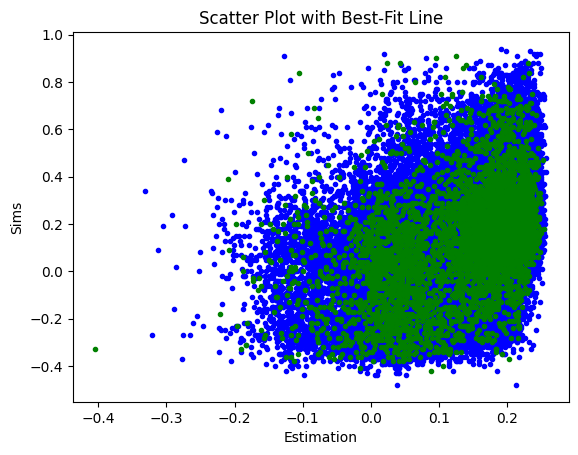







epoch 100
train loss: 0.09076168656237647
test loss: 0.09153143257556345
Correlation train: 0.45906198419951727
Correlation test: 0.4569907398835012


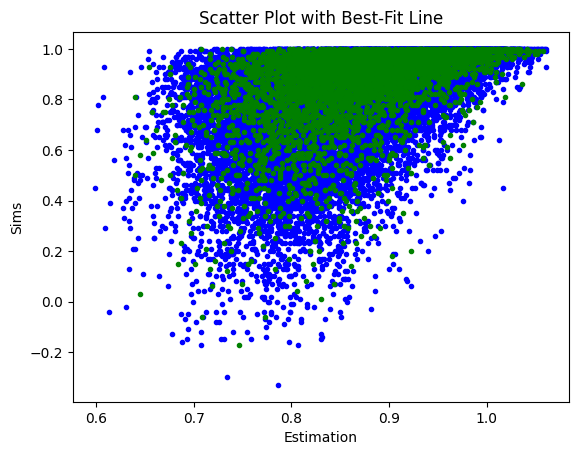







epoch 200
train loss: 0.08098350340741803
test loss: 0.08210448164057853
Correlation train: 0.44069793615607006
Correlation test: 0.44301865416258734


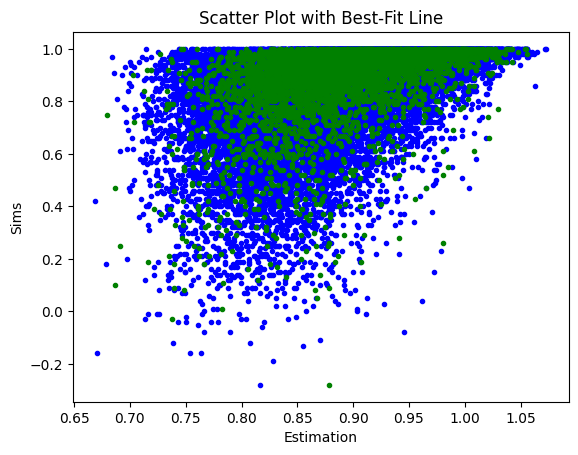







epoch 300
train loss: 0.07589422062473271
test loss: 0.07717020005521999
Correlation train: 0.4271265706570158
Correlation test: 0.42826206041102316


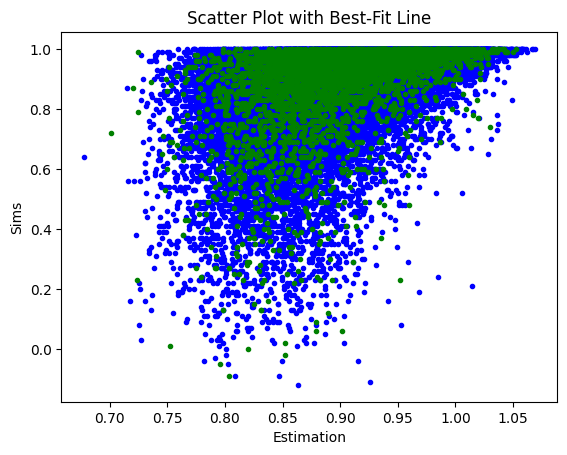







epoch 400
train loss: 0.07213407645197731
test loss: 0.07132168300163473
Correlation train: 0.41030767928544426
Correlation test: 0.41730549788027205


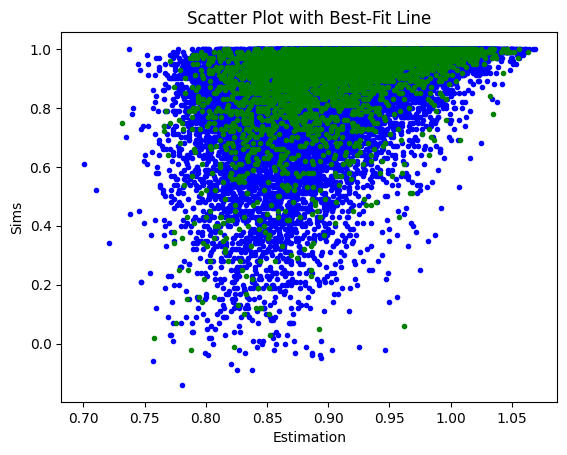







epoch 500
train loss: 0.06481245745329353
test loss: 0.06543203453199846
Correlation train: 0.4036993837028835
Correlation test: 0.3960273550445274


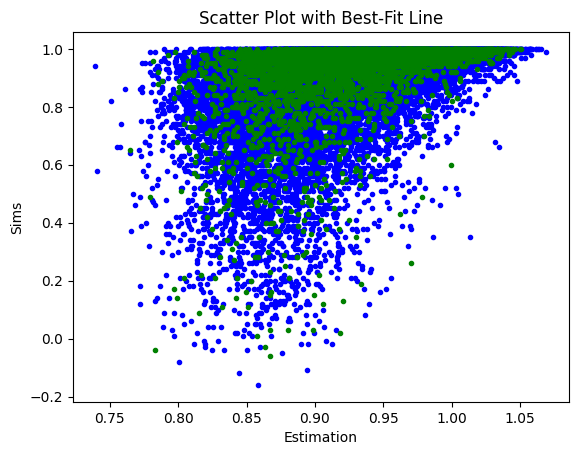







epoch 600
train loss: 0.05434045931689167
test loss: 0.054563717852887016
Correlation train: 0.3777016666428027
Correlation test: 0.35507610468336187


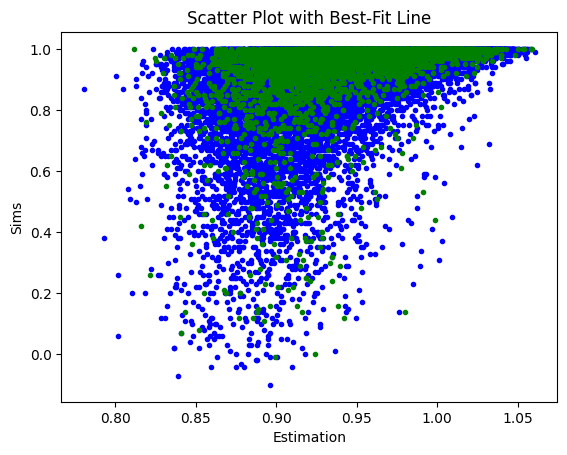







epoch 700
train loss: 0.03844234041397855
test loss: 0.03770749479887728
Correlation train: 0.32738723263668273
Correlation test: 0.317323911899907


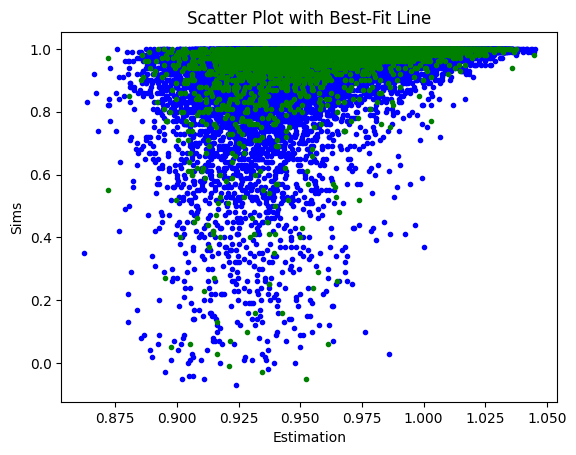







epoch 799
train loss: 0.030030441107484176
test loss: 0.03001757308431933
Correlation train: 0.3017568252142452
Correlation test: 0.3007411776192965


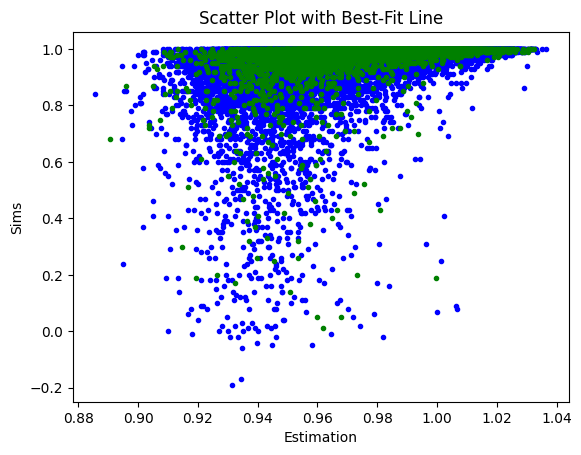

: 

In [12]:
for i in [0, 100, 200, 300, 400, 500, 600, 700, 799]:
    print(f'epoch {i}')
    vectors, sims = epoch2vectors(epochs_lines[i])
    estimator = get_hardness_estimator(vectors, sims)
    print('\n\n\n\n\n')

---

In [9]:
import torch
import torch.nn.functional as F

device = 'cpu'
temperature = 0.07

In [37]:
z1 = torch.rand((256, 128))
z2 = torch.rand((256, 128))

weights = torch.rand((256))



batch_size = z1.shape[0]
        
features = torch.cat((z1, z2), dim=0)

labels = torch.cat([torch.arange(batch_size) for i in range(2)], dim=0).to(device)
labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

features = F.normalize(features, dim=1)

full_similarity_matrix = torch.matmul(features, features.T)

mask = torch.eye(labels.shape[0], dtype=torch.bool).to(device)
labels = labels[~mask].view(labels.shape[0], -1)
similarity_matrix = full_similarity_matrix[~mask].view(full_similarity_matrix.shape[0], -1)

# select and combine multiple positives
positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

# select only the negatives the negatives
negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

logits = torch.cat([positives, negatives], dim=1)
logits = logits / temperature


log_probs = F.log_softmax(logits, dim=1)
loss = -log_probs[:, 0]

weights = torch.cat([weights, weights])
loss = loss * weights
loss = loss.mean()